# Dump Leakage Calorimeter

## Imports and Definitions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot as uproot
import h5py as h5py

from scipy.optimize import curve_fit, root
from scipy.constants import elementary_charge
from mpl_toolkits.axes_grid1 import make_axes_locatable

from helperFunctions import *

In [2]:
# plot settings, increase font sizes
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.labelspacing'] = 0.2

## Beamspot

In [6]:
# camera calibration in [mm/px]
camXconv = 10.8 / 1e3
camYconv = 11.4 / 1e3

# load the preprocessed camera data
bg_roi = np.load('processed/cameraBeamspot.npz')['bg_roi']
cam_roi = np.load('processed/cameraBeamspot.npz')['cam_roi']

# subtract the background from the signal
cam_roi -= bg_roi

# calculate the projection to the horizontal and vertical axes
cam_py = cam_roi.mean(axis=1)
cam_px = cam_roi.mean(axis=0)

# calculate the FWHM in both directions
print('FWHM')
print(f'X: {camXconv*np.sum(cam_px>cam_px.max()/2):.1f} mm')
print(f'Y: {camYconv*np.sum(cam_py>cam_py.max()/2):.1f} mm')

FWHM
X: 0.2 mm
Y: 0.6 mm


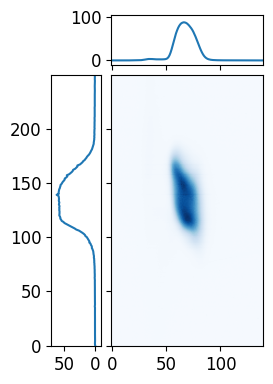

In [7]:
fig, ax = plt.subplots(figsize=(4,4))

# the scatter plot:
cax = ax.imshow(cam_roi, origin='lower', cmap='Blues')
#fig.colorbar(cax)

# create new Axes on the right and on the top of the current Axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 0.5, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("left", 0.5, pad=0.1, sharey=ax)

# make some labels invisible
ax.yaxis.set_tick_params(labelleft=False)
ax_histx.xaxis.set_tick_params(labelbottom=False)
#ax_histy.yaxis.set_tick_params(labelleft=False)

ax_histx.plot(np.arange(len(cam_px)), cam_px)
ax_histx.set(ylim=(-10, 105))

ax_histy.plot(cam_py, np.arange(len(cam_py)))
ax_histy.set(xlim=(70,-10))

fig.tight_layout()

plt.show()

## Position

In [40]:
nCH = 2
channels = [2,6]

In [41]:
# measurement from horizontal scan
runs = np.array([4, 5, 6, 7, 8])

posX = np.zeros((2, len(runs)))
posY = np.zeros((2, len(runs)))
charge = np.zeros(0)

sig = np.zeros((nCH, 2, len(runs)))

for r,run in enumerate(runs):

    posX[:,r] = meanWithError(getDOOCS(run, 'posX'))
    posY[:,r] = meanWithError(getDOOCS(run, 'posY'))
    charge = np.append(charge, getDOOCS(run, 'charge'))
    
    for c,ch in enumerate(channels):
        sig[c,:,r] = meanWithError(getCALO(run, ch, 'int'))

bunch charge: (99 +/- 1) pC


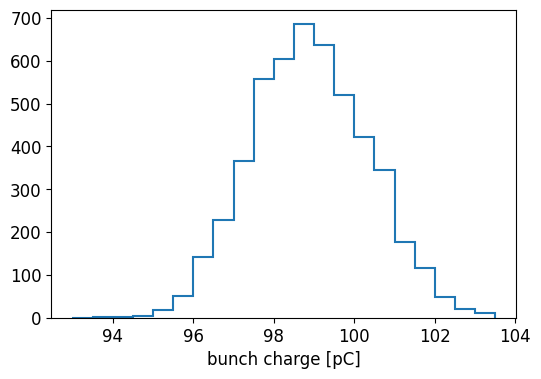

In [60]:
print(f'bunch charge: ({charge.mean():.0f} +/- {charge.std():.0f}) pC')

bins = np.arange(np.floor(charge.min()),np.ceil(charge.max()),0.5)

fig, ax = plt.subplots()
ax.hist(charge, bins, histtype='step', lw=1.5)
ax.set(xlabel='bunch charge [pC]', ylabel='number of events per 0.5 pV')
plt.show()

CH2
(3.74 +/- 0.01) mV×µs/mm
position precision: 9 µm

CH6
(-3.69 +/- 0.01) mV×µs/mm
position precision: 9 µm

Mean 2/6
(0.02 +/- 0.01) mV×µs/mm


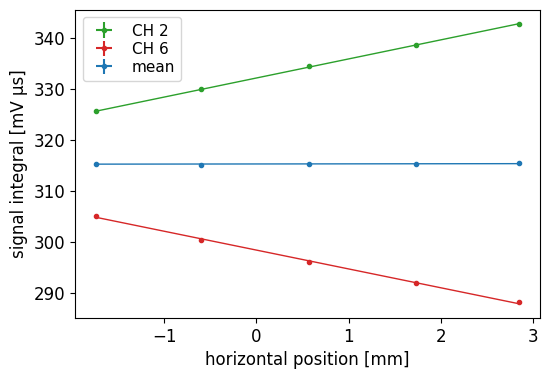

In [99]:
with plt.rc_context():

    fig, ax = plt.subplots()
    
    for i,ch in enumerate([2,6]):
        
        popt, pcov = curve_fit(linFct, posX[0], sig[i,0], sigma=sig[i,1], absolute_sigma=True)
        perr = np.sqrt(np.diag(pcov))
        print(f'CH{ch}')
        print(f'({popt[0]:.2f} +/- {perr[0]:.2f}) mV×µs/mm')

        N = 10000
        a = np.random.normal(popt[0], perr[0], N)
        b = np.random.normal(popt[1], perr[1], N)
        y = np.random.normal((linFct(0, *popt)), sig[i][1].mean(), N)
        x = (y-b)/a
        print(f'position precision: {1e3*x.std():.0f} µm\n')
        
        ax.errorbar(posX[0], *sig[i], posX[1], fmt=f'C{i+2}.', label=f'CH {ch}')
        ax.plot(posX[0], linFct(posX[0], *popt), f'C{i+2}', lw=1)

    chmn = [0,1]
    mn = (sig[chmn[0],0]+sig[chmn[1],0])/2, np.sqrt(sig[chmn[0],1]**2+sig[chmn[1],1]**2)/2
    popt, pcov = curve_fit(linFct, posX[0], mn[0], sigma=mn[1], absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    print(f'Mean {channels[0]}/{channels[1]}')
    print(f'({popt[0]:.2f} +/- {perr[0]:.2f}) mV×µs/mm')
    ax.errorbar(posX[0], *mn, posX[1], fmt='C0.', label='mean')
    ax.plot(posX[0], linFct(posX[0], *popt), 'C0', lw=1)

    ax.legend()
    
    ax.set(xlabel='horizontal position [mm]', ylabel='signal integral [mV µs]')
    
    plt.show()

## Charge Calibration

In [5]:
# sampling time in [ns]
samplingTime = 2

# number of channels and channel array
nPMT = 8
chPMT = np.arange(nPMT)

nSC = 4
chSC = np.arange(nSC) + 8

nALL = nPMT+nSC
chALL = np.concatenate((chPMT,chSC))

# number of samples taken
nSamples = 1000

# radial position of the calorimeter rods in [mm]
R = 161

# define the positions of the calorimeter rods in polar coordinates in [mm,rad]
positions_polar = np.array([np.repeat(R, nPMT), 
                            -np.pi/4*np.arange(nPMT)+np.pi/2]).T

# calculate the positions of the calorimeter rods in cartesian coordinates in [mm,mm]
positions_cartesian = np.array([positions_polar[:,0]*np.cos(positions_polar[:,1]),
                                positions_polar[:,0]*np.sin(positions_polar[:,1])]).T

In [6]:
# beam energy in [Mev]
energy_03 = 1020.2

runs = [219, 220, 222, 223, 224, 225, 227]

charges = np.zeros((2, len(runs)))
integral = np.zeros((nPMT, 2, len(runs)))

for r,run in enumerate(runs):

    charges[:,r] = meanWithError(getDOOCS(run))
    
    for ch in chPMT:
        integral[ch,:,r] = meanWithError(getCALO(run, ch, 'int'))

chmn = [2,6]
integral = np.array([(integral[chmn[0],0]+integral[chmn[1],0])/2, np.sqrt(integral[chmn[0],1]**2+integral[chmn[1],1]**2)/2])

charges_03 = charges
integral_03 = integral

In [7]:
# beam energy in [MeV]
energy_04 = 1200

# Runs
runs = [307, 306, 305, 304, 303]

charges = np.zeros((2, len(runs)))
integral = np.zeros((nPMT, 2, len(runs)))

# get charge and calorimeter data
for r,run in enumerate(runs):
    
    charges[:,r] = meanWithError(getDOOCS(run))

    for ch in chPMT:
        integral[ch,:,r] = meanWithError(getCALO(run, ch, 'int'))

integral = np.array([(integral[chmn[0],0]+integral[chmn[1],0])/2, np.sqrt(integral[chmn[0],1]**2+integral[chmn[1],1]**2)/2])

charges_04 = charges
integral_04 = integral

In [8]:
# use 38 pC point as an energy calibration point
energyCal = ratio(integral_04[:,0], integral_03[:,5])
print(f'{energyCal[0]:.03f} +/- {energyCal[1]:.03f}')

1.068 +/- 0.002


In [23]:
fitFct = lambda x, p0, p1, p2, Ce=1: Ce * (p2*x**2 + p1*x + p0)

popt=(1,1,1)
popt, pcov = curve_fit(fitFct, charges_03[0], integral_03[0], sigma=integral_03[1], absolute_sigma=True, p0=popt)
perr = np.sqrt(np.diag(pcov))
chi2 = np.sum((integral_03[0]-fitFct(charges_03[0], *popt))**2/integral_03[1]**2)
ndf = len(charges_03[0]) - len(popt)
print(f'{chi2:.1f} / {ndf}')

345.1 / 4


In [76]:
N_MC = 10000

N_Meas = len(charges_04[0])

iCal = np.identity(N_Meas, dtype=bool)

energyCal = np.zeros((N_Meas, 2))

for i in range(N_Meas):

    mcParams = np.array([np.random.normal(charges_04[0][iCal[i]],charges_04[1][iCal[i]],N_MC), 
                         np.random.normal(integral_04[0][iCal[i]],integral_04[1][iCal[i]],N_MC), 
                         np.random.normal(popt[0],perr[0],N_MC), 
                         np.random.normal(popt[1],perr[1],N_MC), 
                         np.random.normal(popt[2],perr[2],N_MC)]).T

    OPT = np.empty(N_MC)
    for n_mc in range(N_MC):
        popt_cal, _ = curve_fit(lambda x, p3: fitFct(x, *mcParams[n_mc,2:], p3), [mcParams[n_mc,0]], [mcParams[n_mc,1]], p0=(1))
        OPT[n_mc] = popt_cal[0]

    energyCal[i] = OPT.mean(), OPT.std()
    print(f'i={i}: {energyCal[i,0]:.03f} +/- {energyCal[i,1]:.03f}')

/tmp/ipykernel_763500/1587770365.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_cal, _ = curve_fit(lambda x, p3: fitFct(x, *mcParams[n_mc,2:], p3), [mcParams[n_mc,0]], [mcParams[n_mc,1]], p0=(1))


i=0: 1.082 +/- 0.003
i=1: 1.085 +/- 0.003
i=2: 1.079 +/- 0.003
i=3: 1.072 +/- 0.004
i=4: 1.074 +/- 0.005


In [77]:
charges_04[0,2]

93.19010016879562

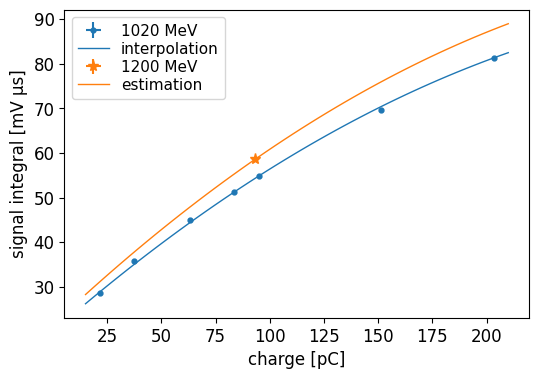

In [82]:
chargesFit = np.linspace(15, 210)

with plt.rc_context():

    fig, ax = plt.subplots()
    
    ax.errorbar(charges_03[0], *integral_03, charges_03[1], fmt='C0.', ms=7, label='1020 MeV')
    ax.errorbar(chargesFit, fitFct(chargesFit, *popt), fmt='C0-', lw=1, label='interpolation')
    
    for i in [2]:
        ax.errorbar(charges_04[0,i], integral_04[0,i], integral_04[1,i], charges_04[1,i], fmt='C1*', ms=8, label='1200 MeV')
        ax.errorbar(chargesFit, energyCal[i,0]*fitFct(chargesFit, *popt), fmt='C1-', lw=1, label='estimation')
    
    ax.legend()
    ax.set(xlabel='charge [pC]', ylabel='signal integral [mV µs]')
    
    plt.show()

In [46]:
N_MC = 10000

i = 2

chargeEst = np.zeros((len(integral_04[0,~iCal[i]]),2))

for j,i04 in enumerate(zip(*integral_04[:,~iCal[i]])):
    
    mcParams = np.array([np.random.normal(*i04, N_MC), 
                         np.random.normal(*energyCal[i], N_MC), 
                         np.random.normal(popt[0],perr[0],N_MC), 
                         np.random.normal(popt[1],perr[1],N_MC), 
                         np.random.normal(popt[2],perr[2],N_MC)]).T

    OPT = np.empty(N_MC)
    for n_mc in range(N_MC):
        opt = root(lambda q0: mcParams[n_mc,0] - mcParams[n_mc,1] * fitFct(q0, *mcParams[n_mc,2:]), x0=100)
        OPT[n_mc] = opt.x
    
    chargeEst[j] = OPT.mean(), OPT.std()

/tmp/ipykernel_763500/511129384.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  OPT[n_mc] = opt.x


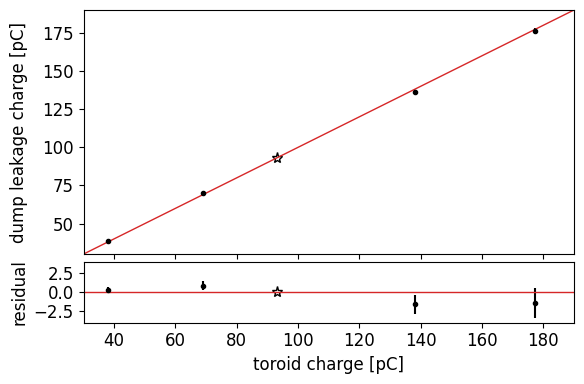

In [75]:
chargeEq = np.linspace(20, 200)

with plt.rc_context(regu):

    fig, ax = plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios':[4,1]})
    
    ax[0].errorbar(charges_04[0,~iCal[i]], chargeEst[:,0], chargeEst[:,1], charges_04[1,~iCal[i]], fmt='C5.')
    ax[0].plot(charges_04[0,iCal[i]], charges_04[0,iCal[i]], 'C5*', ms=8, fillstyle='none')
    ax[0].plot(chargeEq, chargeEq, 'C3-', lw=1)
    ax[0].set(ylabel='dump leakage charge [pC]', ylim=(30,190))
    
    ax[1].errorbar(charges_04[0,~iCal[i]], chargeEst[:,0]-charges_04[0,~iCal[i]], chargeEst[:,1], fmt='C5.')
    ax[1].plot(charges_04[0,iCal[i]], 0, 'C5*', ms=8, fillstyle='none')
    ax[1].axhline(0, c='C3', ls='-', lw=1)
    ax[1].set(xlabel='toroid charge [pC]', ylabel='residual', xlim=(30,190), ylim=(-4,4))
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)
    fig.align_ylabels(ax)
    plt.show()

In [84]:
N_MC = 10000

chargeEst = np.zeros((N_Meas, len(integral_04[0,~iCal[i]]), 2))

for i in range(N_Meas):

    for j,i04 in enumerate(zip(*integral_04[:,~iCal[i]])):
        
        mcParams = np.array([np.random.normal(*i04, N_MC), 
                             np.random.normal(*energyCal[i], N_MC), 
                             np.random.normal(popt[0],perr[0],N_MC), 
                             np.random.normal(popt[1],perr[1],N_MC), 
                             np.random.normal(popt[2],perr[2],N_MC)]).T
    
        OPT = np.empty(N_MC)
        for n_mc in range(N_MC):
            opt = root(lambda q0: mcParams[n_mc,0] - mcParams[n_mc,1] * fitFct(q0, *mcParams[n_mc,2:]), x0=100)
            OPT[n_mc] = opt.x
        
        chargeEst[i,j] = OPT.mean(), OPT.std()

/tmp/ipykernel_763500/1174598761.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  OPT[n_mc] = opt.x


In [85]:
i = 1
print(f'reference charge: {charges_04[0,i]:.0f} pC')

# relative precision in [%]
relPrec = 1e2 * chargeEst[i,:,1] / chargeEst[i,:,0]
print('\nprecision')
print('\n'.join('{:4.0f} pC: {:+.1f}%'.format(Q,D) for Q,D in zip(charges_04[0,~iCal[i]], relPrec)))

# relative accuract in [%]
relAcc = 1e2 * (chargeEst[i,:,0]-charges_04[0,~iCal[i]]) / charges_04[0,~iCal[i]]
print('\naccuracy')
print('\n'.join('{:4.0f} pC: {:+.1f}%'.format(Q,D) for Q,D in zip(charges_04[0,~iCal[i]], relAcc)))

# significance of difference in [sigma]
relDiff = (chargeEst[i,:,0]-charges_04[0,~iCal[i]]) / np.sqrt(chargeEst[i,:,1]**2+charges_04[1,~iCal[i]]**2)
print('\nsignificance')
print('\n'.join('{:4.0f} pC: {:+.1f}σ'.format(Q,D) for Q,D in zip(charges_04[0,~iCal[i]], relDiff)))

reference charge: 69 pC

precision
  38 pC: +1.0%
  93 pC: +0.8%
 138 pC: +0.9%
 177 pC: +1.1%

accuracy
  38 pC: -0.8%
  93 pC: -1.1%
 138 pC: -2.3%
 177 pC: -2.1%

significance
  38 pC: -0.8σ
  93 pC: -1.4σ
 138 pC: -2.6σ
 177 pC: -1.9σ


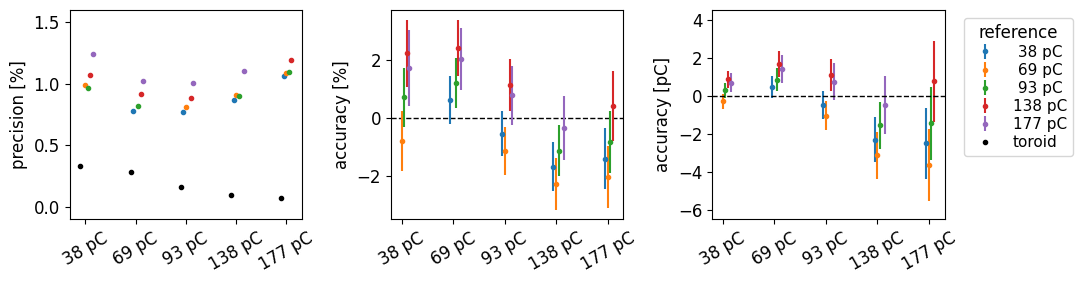

In [89]:
with plt.rc_context(regu):

    fig, ax = plt.subplots(1, 3, figsize=(11,3))
    
    ax[0].errorbar(np.arange(N_Meas)-0.1, 1e2*charges_04[1]/charges_04[0], fmt='C5.', label='toroid')
    
    for i in range(N_Meas):
        ax[0].errorbar(np.arange(N_Meas)[~iCal[i]]+0.05*(i+1)-0.1, 1e2*chargeEst[i,:,1]/chargeEst[i,:,0], 
                    fmt='.', label=f'{charges_04[0,i]:.0f} pC')
    
    ax[0].set(ylabel='precision [%]', xticks=(np.arange(N_Meas)), ylim=(-0.1,1.6))
    ax[0].set_xticklabels(['{:.0f} pC'.format(Q) for Q in charges_04[0]], rotation=30)
    
    
    
    ax[1].axhline(0, c='C5', ls='--', lw=1)
    
    for i in range(N_Meas):
        ax[1].errorbar(np.arange(N_Meas)[~iCal[i]]+0.05*(i+1)-0.1, 1e2*(chargeEst[i,:,0]-charges_04[0,~iCal[i]])/charges_04[0,~iCal[i]], 
                    yerr=1e2*np.sqrt(chargeEst[i,:,1]**2+charges_04[1,~iCal[i]]**2)/charges_04[0,~iCal[i]],
                    fmt='.', label=f'{charges_04[0,i]:3.0f} pC')
    
    ax[1].set(ylabel='accuracy [%]', xticks=(np.arange(N_Meas)))
    ax[1].set_xticklabels(['{:.0f} pC'.format(Q) for Q in charges_04[0]], rotation=30)
    
    
    for i in range(N_Meas):
        ax[2].errorbar(np.arange(N_Meas)[~iCal[i]]+0.05*(i+1)-0.1, chargeEst[i,:,0]-charges_04[0,~iCal[i]], np.sqrt(chargeEst[i,:,1]**2+charges_04[1,~iCal[i]]**2),
                    fmt='.', label=f'{charges_04[0,i]:3.0f} pC')

    ax[2].errorbar(np.nan, np.nan, fmt='C5.', label='toroid')
    ax[2].axhline(0, c='C5', ls='--', lw=1)
    
    ax[2].set(ylabel='accuracy [pC]', ylim=(-6.5,4.5), xticks=(np.arange(N_Meas)))
    ax[2].set_xticklabels(['{:.0f} pC'.format(Q) for Q in charges_04[0]], rotation=30)
    
    
    ax[2].legend(loc='upper left', title='reference', bbox_to_anchor=(1.05,1))
    
    fig.tight_layout()
    plt.show()

## Comparison Electrons / Photons

In [69]:
# actual bunch charge [pC]
qBX = 100e-12

# number of particles in a bunch
nBX = qBX / elementary_charge

# number of simulated particles
nSimPart = 1e5

# scaling factor
scaling = nBX / nSimPart

In [70]:
# load the pre-processed data set
df = pd.read_csv('processed/g4bl_simulationData.csv')

# simulated energies in [GeV]
Energy = sorted(set(df['energy_GeV']))

In [71]:
edep_electron = np.zeros((2,len(Energy)))
edep_photon = np.zeros((2,len(Energy)))

for i,energy in enumerate(Energy):

    # load the electron data
    mask = (df['particle']=='electron') & (df['energy_GeV']==energy)
    edep = df[mask]['Edep_GeV']
    edep_electron[:,i] = edep.mean(), edep.std()

    # load the photon data
    mask = (df['particle']=='photon') & (df['energy_GeV']==energy)
    edep = df[mask]['Edep_GeV']
    edep_photon[:,i] = edep.mean(), edep.std()

# scale the deposited energy to a full bunch crossing and convert to [TeV]
edep_electron = scaling * edep_electron / 1e3
edep_photon = scaling * edep_photon / 1e3

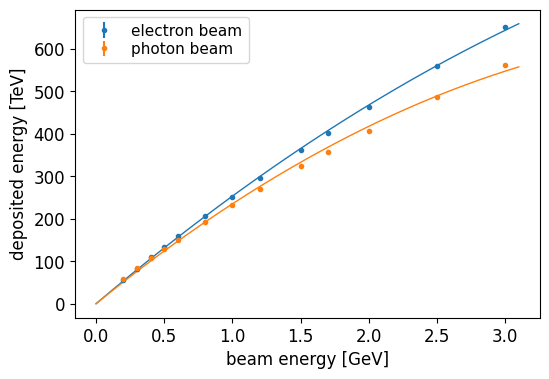

In [72]:
eFit = np.linspace(0, 3.1, 1001)

fig, ax = plt.subplots()

popt, pcov = curve_fit(quadFct, Energy, edep_electron[0], sigma=edep_electron[1], absolute_sigma=True, p0=(1,1))
perr = np.sqrt(np.diag(pcov))
ax.errorbar(Energy, *edep_electron, fmt='C0.', label='electron beam')
ax.plot(eFit, quadFct(eFit, *popt), 'C0-', lw=1)

popt, pcov = curve_fit(quadFct, Energy, edep_photon[0], sigma=edep_photon[1], absolute_sigma=True, p0=(1,1))
perr = np.sqrt(np.diag(pcov))
ax.errorbar(Energy, *edep_photon, fmt='C1.', label='photon beam')
ax.plot(eFit, quadFct(eFit, *popt), 'C1-', lw=1)

ax.legend()
ax.set(xlabel='beam energy [GeV]', ylabel='deposited energy [TeV]')

plt.show()